

# **#3 Collaborative filtering: ALS, BM25 and TF-IDF weights**
[“Collaborative Filtering for Implicit Feedback Datasets” by Koren et.al.](http://yifanhu.net/PUB/cf.pdf)_(pdf)_


Ответы на вопросы:

- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)

_Можно разделить датасет по продуктам со скидкой и без, обучив при этом модель на полном наборе, использовать параметр N в методе recommend(?)_
_В user-item матрице должна учитываться последняя актуальная информация - то есть будем брать товар с 50% скидкой_ 

- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 

_Советовать похожие, проверять есть ли в списке покупок, повторять. Или выбирать из товар top-popular, если он еще не был куплен и не был рекомендован (not in bought_list and not in recommender_list)_

- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

_Высчитать средний чек для каждого юзера и установить порог, добавив к среднему чеку 50-100% от него, к примеру. Можно узнать, насколько в среднем юзеры готовы превышать свой средний чек, чтобы получить более обоснованный коэффициент. Либо отсортировать по убыванию цены популярные товары, установить порог выше среднего чека и выбирать из них наиболее близкий к покупкам_

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


from src.metrics import precision_at_k, recall_at_k

### Read and prepare retail_train data

In [2]:
data = pd.read_csv('../2_baselines_implicit/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)

### Train-test split

In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


### Read and prepare item data

In [4]:
item_features = pd.read_csv('./product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
np.array(sorted(item_features.department.unique()))

array([' ', 'AUTOMOTIVE', 'CHARITABLE CONT', 'CHEF SHOPPE',
       'CNTRL/STORE SUP', 'COSMETICS', 'COUP/STR & MFG', 'DAIRY DELI',
       'DELI', 'DELI/SNACK BAR', 'DRUG GM', 'ELECT &PLUMBING', 'FLORAL',
       'FROZEN GROCERY', 'GARDEN CENTER', 'GM MERCH EXP', 'GRO BAKERY',
       'GROCERY', 'HBC', 'HOUSEWARES', 'KIOSK-GAS', 'MEAT', 'MEAT-PCKGD',
       'MEAT-WHSE', 'MISC SALES TRAN', 'MISC. TRANS.', 'NUTRITION',
       'PASTRY', 'PHARMACY SUPPLY', 'PHOTO', 'PORK', 'POSTAL CENTER',
       'PROD-WHS SALES', 'PRODUCE', 'RESTAURANT', 'RX', 'SALAD BAR',
       'SEAFOOD', 'SEAFOOD-PCKGD', 'SPIRITS', 'TOYS', 'TRAVEL & LEISUR',
       'VIDEO', 'VIDEO RENTAL'], dtype='<U15')

### Create purchases dataframe with unique users for storing different recommendations

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Build model

In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/home/alina/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### **Подбор матрицы $c_{ui}$**

In [9]:
user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id',
                                  columns='item_id',
                                  values='quantity',
                                  aggfunc='count',
                                  fill_value=0
                                  ).astype(float)

sparse_user_item = csr_matrix(user_item_matrix).tocsr()
user_item_matrix.head()

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
user_ids = user_item_matrix.index.values
item_ids = user_item_matrix.columns.values

matrix_user_ids = np.arange(len(user_ids))
matrix_item_ids = np.arange(len(item_ids))

id_to_itemid = dict(zip(matrix_item_ids, item_ids))
id_to_userid = dict(zip(matrix_user_ids, user_ids))

itemid_to_id = dict(zip(item_ids, matrix_item_ids))
userid_to_id = dict(zip(user_ids, matrix_user_ids))

In [11]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res


model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

100%|██████████| 15/15 [00:07<00:00,  2.13it/s, loss=0.0409]


0.15945151811948863

In [ ]:

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

#### BM25 weight

In [12]:
user_item_matrix = bm25_weight(user_item_matrix.T).T

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=True)
result['ALS_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['ALS_bm25'], row['actual']), axis=1).mean()

100%|██████████| 15/15 [00:07<00:00,  1.90it/s, loss=0.0812]


0.1935357492654232

#### TF-IDF weight

In [13]:
%%time
user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id',
                                  columns='item_id',
                                  values='quantity',
                                  aggfunc='count',
                                  fill_value=0
                                  ).astype(float)
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix = tfidf_weight(user_item_matrix.T).T

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['ALS_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['ALS_tfidf'], row['actual']), axis=1).mean()

100%|██████████| 15/15 [00:06<00:00,  2.17it/s, loss=0.0687]


CPU times: user 2min 5s, sys: 4.83 s, total: 2min 10s
Wall time: 1min 1s


0.1671890303623875

In [14]:
def prefilter_items(data):

    print('== Starting prefilter info ==')
    n_users = data.user_id.nunique()
    n_items = data.item_id.nunique()
    sparsity = float(data.shape[0]) / float(n_users*n_items) * 100
    print('# users: {}'.format(n_users))
    print('# items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    # do not use top popular items (they'd be bought anyway)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
    popularity['user_id'] = popularity['user_id'] / data_train.user_id.nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    top_popular = popularity[popularity['share_unique_users'] > .5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]

    # do not use top not popular
    top_not_popular = popularity[popularity.share_unique_users < .001].item_id.tolist()
    data = data[~data.item_id.isin(top_not_popular)]

    # do not use items that have not been sold in the last 12 month
    num_weeks = 12*4
    start_week = data_train.week_no.max() - num_weeks
    data = data[data.week_no >= start_week]

    # do not use not popular departments
    not_popular_departments = item_features[
        item_features.department.isin(
            item_features[item_features.item_id.isin(top_not_popular)].department.unique()
            )
        ].item_id.tolist()
    data = data[~data.item_id.isin(not_popular_departments)]

    # do not use too expensive and too cheap items
    high_cost_threshold = data_train.sales_value.quantile(.99995)
    low_cost_threshold = data_train.sales_value.quantile(.11)
    data = data[
        (data.sales_value < high_cost_threshold)
        &
        (data.sales_value > low_cost_threshold)
        ]    

    # do not use too popular stores
    store_df = data.groupby('store_id')['user_id'].nunique().reset_index()
    data = data[~data.store_id.isin(
        store_df[store_df.user_id > store_df.user_id.quantile(.985)].store_id.tolist()
    )]

    print('== Starting prefilter info ==')
    n_users = data.user_id.nunique()
    n_items = data.item_id.nunique()
    sparsity = float(data.shape[0]) / float(n_users*n_items) * 100
    print('# users: {}'.format(n_users))
    print('# items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return data

filtered_data_train = prefilter_items(data_train.copy())


== Starting prefilter info ==
# users: 2499
# items: 5001
Sparsity: 18.232%
== Starting prefilter info ==
# users: 2421
# items: 4916
Sparsity: 5.708%


### Hyperparameter Optimisation


In [111]:
import time 
res = {'time': [], 'param': {'name': [], 'value': []}}
user_item_matrix_train = pd.pivot_table(data_train,
                                  index='user_id',
                                  columns='item_id',
                                  values='quantity',
                                  aggfunc='count',
                                  fill_value=0
                                  ).astype(float)
user_item_matrix_test = pd.pivot_table(data_test,
                                  index='user_id',
                                  columns='item_id',
                                  values='quantity',
                                  aggfunc='count',
                                  fill_value=0
                                  ).astype(float)

for user_item_matrix in (user_item_matrix_train):
    for factor in [50, 100]:
        for lambda_ in [0.001, 0.01, 0.1]:
            start_time = time.time()
            model = AlternatingLeastSquares(factors=factor, 
                                            regularization=lambda_, 
                                            iterations=15, 
                                            calculate_training_loss=True, 
                                            use_gpu=False, 
                                            num_threads=4)
            conf_matrix = csr_matrix(user_item_matrix_train).T.tocsr()
            model.fit(conf_matrix, show_progress=False)
            res[f'time'].append(time.time() - start_time)
            res['param']['name'].append(f'{factor}_{lambda_}')
            res['param']['value'].append(result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5)))
            print(res)
res

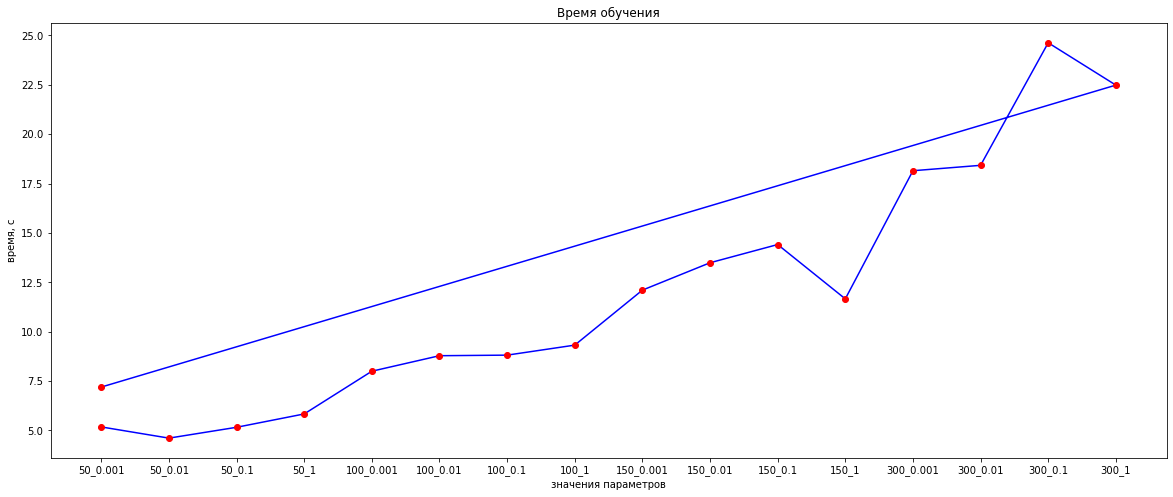

In [86]:
labels = list(res['param']['name'])
times = list(res['time']) 

plt.figure(figsize=(20, 8))
plt.title('Время обучения')
plt.xlabel('значения параметров')
plt.ylabel('время, с')
plt.plot(labels, times, 'b')
plt.plot(labels, times, 'ro')
plt.show()

In [ ]:
res

{'time': [5.177578687667847,
  4.610712051391602,
  5.159475564956665,
  5.835221767425537,
  7.99874472618103,
  8.784107685089111,
  8.813250541687012,
  9.320204496383667,
  12.104957580566406,
  13.49119234085083,
  14.41368818283081,
  11.662610292434692,
  18.15108060836792,
  18.424596071243286,
  24.630231380462646,
  22.4866361618042,
  7.196837902069092],
 'param': {'name': ['50_0.001',
   '50_0.01',
   '50_0.1',
   '50_1',
   '100_0.001',
   '100_0.01',
   '100_0.1',
   '100_1',
   '150_0.001',
   '150_0.01',
   '150_0.1',
   '150_1',
   '300_0.001',
   '300_0.01',
   '300_0.1',
   '300_1',
   '50_0.001'],
  'value': [0       [1033142, 1056509, 1027569, 1024306, 1100972]
   1         [1106523, 951590, 1133018, 910032, 5568378]
   2        [1007195, 1051516, 986912, 5569230, 1024306]
   3        [1082185, 938700, 12810393, 826249, 6534178]
   4           [883404, 826249, 1005186, 849843, 844179]
                               ...                      
   2037     [844179, 874